# Phishing Site Predictor

The increasing use of the Internet has led to a new way of stealing data, known as cybercrime. Cybercrime refers to stealing private information and violating privacy through computers. The primary technique used is phishing. 

Phishing attacks are fraudulent emails, text message, phone calls, or websites that are designed to trick users into actions like downloading malware, sharing sensitive information or personal data, or any other actions that expose themselves or their organisations to cybercrime.

This work aims to provide a solution for detecting potential phishing website links with the help of machine learning algorithms focused on the behaviors and qualities of the suggested URL.

### Import Libraries

In [1]:
import pandas as pd # use for data manipulation and analysis
import numpy as np # use for multi-dimensional array and matrix
import seaborn as sns # use for high-level interface for drawing attractive and informative statistical graphics
import matplotlib.pyplot as plt # provide object-oriented API for embedding plots into applications
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from bs4 import BeautifulSoup
from selenium import webdriver
import networkx as nx

## O: OBTAIN

### Loading Dataset

In [2]:
phish_data = pd.read_csv('phishing_site_urls.csv')

### Getting to Know the Data

In [3]:
phish_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [4]:
phish_data.tail()

,URL,Label
549341,23.227.196.215/,bad
549342,apple-checker.org/,bad
549343,apple-iclods.org/,bad
549344,apple-uptoday.org/,bad
549345,apple-search.info,bad


In [5]:
phish_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


About the dataset: 
- dataset contains 549,346 unique entries
- there are two columns:
    - URL column containing the website urls
    - Label column containing website url categorisation: good (not a phishing site link) or bad (is a phishing site link)

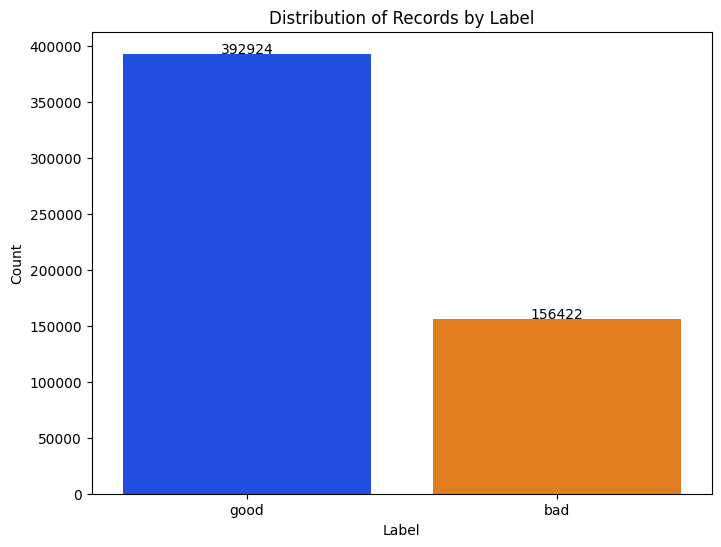

In [6]:
# Count occurence of records for each category in Label column
label_counts = phish_data['Label'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 6))
barplot = sns.barplot(x=label_counts.index, y=label_counts.values, hue=label_counts.index, palette='bright', legend=False)

# Add count values on top of each bar with corresponding color
for i, (index, value) in enumerate(label_counts.items()):
    barplot.text(x=i, y=value + 0.1, s=value, ha='center', color='black')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Records by Label')

# Show the plot
plt.show()

## S: SCRUB

### Missing Values

In [7]:
phish_data.isnull().sum()

URL      0
Label    0
dtype: int64

- There is no missing value in the dataset

### Unifying Labels / Fixing Up Formats

In [8]:
phish_data.sample(20)

,URL,Label
365024,jellyyarns.com/kits.html,good
383444,manta.com/c/mms5th9/east-oakland-fruitvale-pla...,good
389386,militaryspot.com/strategyfirst.htm,good
139547,aaron0884.tripod.com/,good
449052,torontosun.com/sports/football/2010/06/04/1426...,good
120271,liquimeca.com/jojoboi67/CLICK/index.php.htm,bad
543179,dowfrecap.net/6f9tho,bad
354989,househunt.com/MO/Kansas_City_-_North_of_the_Ri...,good
124207,boileri-matev.com/image/data2/dhl/DHL-SHIPPING...,bad
457700,v-twinforum.com/forums/religion-politics/11602...,good


- All records for column "Label" are having the same representation which is in string format "good" or "bad" that categorises the url 

### Duplicate Records

In [9]:
# Check for duplicate records based on all columns
duplicate_rows = phish_data[phish_data.duplicated()]

# Print the duplicate rows
print("Duplicate rows based on all columns:")
print(duplicate_rows)

Duplicate rows based on all columns:
                                                      URL Label
35413                              bin/webscr?cmd=_login-   bad
45184   'www.allegropl.xaa.pl/enter_login.html?session...   bad
96132                       stormpages.com/script/PHP.txt   bad
96449          penwithian.co.uk/hyperventilate/sporran.js   bad
96480                            ukonline.hc0.me/Host.exe   bad
...                                                   ...   ...
549341                                    23.227.196.215/   bad
549342                                 apple-checker.org/   bad
549343                                  apple-iclods.org/   bad
549344                                 apple-uptoday.org/   bad
549345                                  apple-search.info   bad

[42150 rows x 2 columns]


In [10]:
# Remove duplicate rows
phish_data = phish_data.drop_duplicates()

In [11]:
phish_data

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad
...,...,...
516466,23.227.196.215/,bad
516467,apple-checker.org/,bad
516468,apple-iclods.org/,bad
516469,apple-uptoday.org/,bad


In [12]:
# Recheck for duplicate records based on all columns
duplicate_rows = phish_data[phish_data.duplicated()]

# Print the duplicate rows
print("Duplicate rows based on all columns:")
print(duplicate_rows)

Duplicate rows based on all columns:
Empty DataFrame
Columns: [URL, Label]
Index: []


- We have successfully removed the unwanted observations from the dataset which are the duplicate records

### Transforming Variables

RegexpTokenizer
- to extract the alphabet characters, disregarding the non-alphabetic characters from a link in the records in the dataset
- purpose is to extract more features from the data, to classify the web urls as good or bad sites

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')

In [ ]:
phish_data.URL[0]

In [ ]:
# tokenize the first URL
tokenizer.tokenize(phish_data.URL[0])

In [ ]:
# We will tokenize all the rows
# Create a new column named 'text_tokenized' in the phish_data DataFrame
# This column will store the tokens of alphabets extracted from the URLs
phish_data['text_tokenized'] = (
    # Apply a function to each URL in the 'URL' column
    # The function tokenizes each URL using the declared tokenizer object
    phish_data['URL'].map(lambda t: tokenizer.tokenize(t))
)

In [ ]:
phish_data.sample(5)

SnowballStemmer
- is a stemming algorithm used for reducing words to their root or base form (get the root words)
- it is applied after tokenization to further preprocess the text data, normalizing it so that we can better process the text


In [ ]:
stemmer = SnowballStemmer("english")

In [ ]:
# Stemming all the rows
# Create a new column named 'text_stemmed' in the phish_data DataFrame
# Applying stemming to the tokenized words in the 'text_tokenized' column
phish_data['text_stemmed'] = (
    phish_data['text_tokenized'].map(lambda s: 
        # Iterate over each word in the tokenized list
        # and apply stemming using the SnowballStemmer object that we declared earlier
        [stemmer.stem(word) for word in s]
    )
)

In [ ]:
phish_data.sample(5)

We will combine the stemmed words into single strings by joining them together with spaces. It helps to simplify the representation of text data, and making it more suitable for analysis, visualisation, and modeling purposes.

In [ ]:
# Create a new column named 'text_sent' in the DataFrame 'phish_data'
phish_data['text_sent'] = (
    phish_data['text_stemmed'].map(lambda j: 
        # Join the stemmed words in each list into a single string separated by spaces
        ' '.join(j)
    )
)

In [ ]:
phish_data.sample(5)

End Goal of Data Cleaning Stage:
- Each variable is in one column
- Each observation is in one row
- The topmost row is containing the variable names

### Data Visualisation

In [ ]:
# Separate the data frame into bad and good urls
bad_sites = phish_data[phish_data.Label == 'bad']
good_sites = phish_data[phish_data.Label == 'good']

In [ ]:
bad_sites.head()

In [ ]:
good_sites.head()

We will visualise the most common words that appear for bad and good sites respectively

In [ ]:
from collections import Counter
def plot_wordcloud(text, title):
    # Generate word frequency counts
    word_freq = Counter(text.split())
    
    # Exclude default stopwords and additional stopwords
    stopwords = set(STOPWORDS).union({'com', 'http'})
    for stopword in stopwords:
        word_freq.pop(stopword, None)
    
    # Filter out the most common words (up to 400 words)
    common_words = dict(word_freq.most_common(400))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_words)
    
    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Convert text data for bad and good sites into single strings
bad_text = ' '.join(bad_sites['text_sent'])
good_text = ' '.join(good_sites['text_sent'])

In [ ]:
# Plot word cloud for bad sites
plot_wordcloud(bad_text, title='Word Cloud for Bad Sites')

In [ ]:
# Plot word cloud for good sites
plot_wordcloud(good_text, title='Word Cloud for Good Sites')

## E: EXPLORE

### Exploratory Data Analysis

In [ ]:
# visualize the frequency of top level domains (TLDs) for good vs bad URLs
top_tlds_phish = bad_sites['URL'].apply(lambda x: x.split('.')[-1])
top_tlds_good = good_sites['URL'].apply(lambda x: x.split('.')[-1])

In [ ]:
# plot histogram of good vs bad TLDs
plt.figure(figsize=(10, 6))
sns.countplot(y=top_tlds_phish, order=top_tlds_phish.value_counts().index[:10], color='red', alpha=0.7, label='Phishing')
sns.countplot(y=top_tlds_good, order=top_tlds_good.value_counts().index[:10], color='blue', alpha=0.7, label='Legitimate')

plt.title('Top 10 TLDs for Phishing and Legitimate URLs')
plt.xlabel('Frequency')
plt.ylabel('Top-Level Domain (TLD)')
plt.legend()
plt.show()

In [ ]:
# statistical Analysis
# calculate the mean URL length for phishing and legit URLs
mean_url_length_phishing = bad_sites['URL'].apply(len).mean()
mean_url_length_legitimate = good_sites['URL'].apply(len).mean()

print("Mean URL length (phishing):", mean_url_length_phishing)
print("Mean URL length (legitimate):", mean_url_length_legitimate)

In [ ]:
# further statistical explaination
url_length_stats = phish_data.groupby('Label')['URL'].apply(lambda x: x.str.len().describe())
print("URL Length Statistics:")
print(url_length_stats)

In [ ]:
# function to count the frequency of keywords in URLs
def count_keywords(urls, keyword):
    return sum(url.count(keyword) for url in urls)

# keywords of interest (change whenever necessary)
keywords = ['login', 'bank', 'search', 'secure', 'account']

# count keyword frequencies in good and bad sites
keyword_counts_good = {keyword: count_keywords(good_sites['URL'], keyword) for keyword in keywords}
keyword_counts_bad = {keyword: count_keywords(bad_sites['URL'], keyword) for keyword in keywords}

# plot bar chart
plt.figure(figsize=(10, 6))
plt.bar(keyword_counts_good.keys(), keyword_counts_good.values(), color='green', alpha=0.7, label='Good Sites')
plt.bar(keyword_counts_bad.keys(), keyword_counts_bad.values(), color='yellow', alpha=0.7, label='Bad Sites')
plt.title('Keyword Frequency in Good and Bad Sites')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.legend()
plt.show()